# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

In [6]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch
import pickle

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

In [ ]:
env = UnityEnvironment(file_name="./environment/Tennis.exe")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [9]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [10]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [11]:
env_info.local_done

[False, False]

### 3. Train the agent

In [12]:
def run_experiment(agent, n_episodes=300, max_t=1000, stop_if_solved=True, abort_threshold=None):
    """MADDPG training.
    
    Params
    ======
        agent (Agent): the MADDPG agent
        starting_episode (int):  the starting episode number
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        stop_if_solved (boolean): true, if training has to stop when the agent solved the environment
        abort_threshold (int): abort training if the agent has scored high enough untis this episode
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores 

    # beta is only used by agents using PER
    beta_min = 0.4
    noise_min = 0.1

    solved = False

    def next_discount(t, min_value):
        return min(1.0, min_value + t * (1.0 - min_value) / max_t)

    # noise reduction
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        states = env_info.vector_observations
        score = 0
        for t in range(max_t):
            action1 = agent.act(states[0])
            action2 = agent.act(states[1])
            actions = np.concatenate((action1, action2))
            env_info = env.step(actions)[brain_name]           # send the action to the environment
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done
            beta = next_discount(t, beta_min)
            all_states1 = np.concatenate((states[0], states[1]))
            all_states2 = np.concatenate((states[1], states[0]))
            all_next_states1 = np.concatenate((next_states[0], next_states[1]))
            all_next_states2 = np.concatenate((next_states[1], next_states[0]))
            agent.step(states[0], all_states1, action1, action2, rewards[0], next_states[0], all_next_states1, dones[0], beta)
            agent.step(states[1], all_states2, action2, action1, rewards[1], next_states[1], all_next_states2, dones[1], beta)
            states = next_states
            score += max(rewards)
            if np.any(dones):
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if abort_threshold != None and i_episode > abort_threshold and np.mean(scores_window) < 0.1:
            print("Aborted\n")
            break
        if np.mean(scores_window)>=0.5:
            if not solved:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                solved = True
            if stop_if_solved:
                break
            
    torch.save(agent.actor_local.state_dict(), 'agent_{}_actor_{}.pth'.format(agent.getId(), i_episode-100))
    torch.save(agent.critic_local.state_dict(), 'agent_{}_critic_{}.pth'.format(agent.getId(), i_episode-100))
    with open('agent_{}_{}.txt'.format(agent.getId(), i_episode-100), 'w') as f:
        f.write(agent.summary())
        
    return scores

In [13]:
from src.ddpg import DdpgAgent
from src.config import Config

configs = [
    Config(batch_size=256, use_per=True, add_noise=True, use_bn_actor=True, use_bn_critic=True, noise_type="uniform")
]

agents = [
    DdpgAgent(id=i, state_size=24, action_size=2, config=config) for i, config in enumerate(configs)]

In [14]:
scores = []
for i, agent in enumerate(agents):
    print('\nRunning experiment with agent #{}\n'.format(agent.getId()))
    print(agent.summary()+"\n")
    scores.append(run_experiment(agent, n_episodes=1250, stop_if_solved=False))

pickle.dump(scores, open('scores.dump', 'wb'))


Running experiment with agent #0

MADDPG Agent 0:
Config(buffer_size=1000000, batch_size=256, gamma=0.99, tau=0.001, lr_actor=0.0001, lr_critic=0.0001, weight_decay=0, random_seed=0, update_n_step=20, update_n_times=10, actor_hidden_units=[400, 300], critic_hidden_units=[400, 300], noise_type='uniform', add_noise=True, noise_mu=0.0, noise_theta=0.15, noise_sigma=0.2, use_per=True, per_alpha=0.6, per_beta=0.4, per_epsilon=1e-05, use_bn_actor=True, use_bn_critic=True, use_huber_loss=False)Actor(
  (bns): ModuleList(
    (0): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layers): ModuleList(
    (0): Linear(in_features=24, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=2, bias=True)
  )
)Critic(
  (bn): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [15]:
env.close()

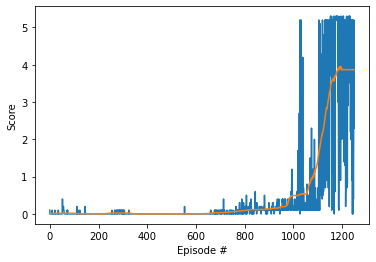

In [21]:
import matplotlib.pyplot as plt
sc = scores[0]
sc = sc + sc[-100:] # for plotting only

# plot the best scores
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

fig = plt.figure()
ax = fig.add_subplot(111)
window = 100
plt.plot(np.arange(len(sc)-window), sc[:-window])
plt.plot(np.arange(len(sc)-window), movingaverage(sc,window)[:-window])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()